<a href="https://colab.research.google.com/github/psicobloc/EDA_SquidGameTweets/blob/main/Entregable_come_verde_Hugo_ValenciaV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Importar las bibliotecas a utilizar:

In [1]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from textblob import TextBlob                   
import pandas as pd
%matplotlib inline

###Cargar el dataset a un DataFrame:



In [2]:
tweets_all = pd.read_csv("tweets_v8.csv")

---
#Exploratory Data Analysis

###Visualizar los primeros 3 tweets para darnos una idea de como lucen los datos

In [3]:
tweets_all.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
0,the _ûndër-ratèd niggáh👊🏾,NaN,@ManUtd die hard❤️❤️💪🏿💪🏿\n\n\nYOLO\n\n\nJ'ai b...,2019-09-06 19:24:57+00:00,581,1035,8922,False,2021-10-06 12:05:38+00:00,When life hits and the same time poverty strik...,Twitter for Android,False
1,Best uncle on planet earth,NaN,NaN,2013-05-08 19:35:26+00:00,741,730,8432,False,2021-10-06 12:05:22+00:00,That marble episode of #SquidGame ruined me. 😭😭😭,Twitter for Android,False
2,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62732,False,2021-10-06 12:05:22+00:00,#Squidgame time,Twitter Web App,False


####Types de cada atributo:

In [4]:
tweets_all.dtypes

user_name           object
user_location       object
user_description    object
user_created        object
user_followers       int64
user_friends         int64
user_favourites      int64
user_verified         bool
date                object
text                object
source              object
is_retweet            bool
dtype: object

####Contar los valores faltantes.

In [5]:
tweets_all.isnull().sum()


user_name               4
user_location       23870
user_description     5211
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
source                  0
is_retweet              0
dtype: int64

###Aquí podemos preguntarnos si, por ejemplo, no nos interesan los tweets que no tienen nombre de usuario, dependiendo de nuestro objetivo, en este caso los eliminaré. Si hubiera instancias donde hace falta el texto del tweet las eliminaríamos pero por suerte no es el caso.

In [6]:
tweets_with_usernames = tweets_all.loc[tweets_all.user_name.notnull()] #también podriamos usar la función dropna()
tweets_with_usernames.isnull().sum() #comprobamos que ya no hay tweets sin usuario

user_name               0
user_location       23866
user_description     5211
user_created            0
user_followers          0
user_friends            0
user_favourites         0
user_verified           0
date                    0
text                    0
source                  0
is_retweet              0
dtype: int64

In [7]:
tweets_with_usernames.loc[tweets_with_usernames.is_retweet==True].text.count()

0

#####Ningúno de los tweets es un retweet, por lo que ignoraremos esa columna

###Ahora nos interesa saber si hay algún usuario que haya hecho más de 1 tweet, sería razonable pensar que son los más interesados, pueden estar interesados porque les gusta o porque no les gusta, aún no podemos saberlo pero lo descubriremos más adelante. ¡otra opción es que sean bots! pero hablaremos de eso también más adelante, cuando creemos nuestra nube de palabras.

In [8]:
tweets_with_usernames.groupby('user_name').count().text >1 # nos da una serie con valores booleanos donde True significa que un mismo usuario hizo más de 1 tweet

# Podemos usar esta serie para seleccionar en el dataframe los usuarios que realizaron más de 1 tweet, guardamos esa selección en tweets_count:

tweets_count = tweets_with_usernames.groupby('user_name').count().loc[tweets_with_usernames.groupby('user_name').count().text >1] 
tweets_count = tweets_count.sort_values('text', ascending=False) 
tweets_count

,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
user_name,,,,,,,,,,,
Sale X Low,395,395,395,395,395,395,395,395,395,395,395
John Doge,263,263,263,263,263,263,263,263,263,263,263
7-Ainu,0,170,170,170,170,170,170,170,170,170,170
Ofofonobs,140,140,140,140,140,140,140,140,140,140,140
havingalaff,0,110,110,110,110,110,110,110,110,110,110
...,...,...,...,...,...,...,...,...,...,...,...
King Cocksman,2,2,2,2,2,2,2,2,2,2,2
Kinetic®,2,2,2,2,2,2,2,2,2,2,2
Kimchi Kooks,2,2,2,2,2,2,2,2,2,2,2


###Podríamos considerar los tweets de usuarios verificado como prioritarios, si nuestro dataset fuera gigante podemos utilizar esta característica como criterio para eliminar los demás con el objetivo de reducir el tamaño del DS y poderlo procesar con menos recursos. Puede ser interesante también comparar las estadísticas de este grupo de usuarios contra la población completa y contra usuarios que publicaron más de un tweet

####Para seleccionar únicamente los tweets de usuarios que publicaron más de 1 :

In [9]:
user_names_multiple_tweets = tweets_count.index #los nombres de los usuarios que realizaron más de 1 tweet
tweets_of_multiple_posting_users = tweets_with_usernames.loc[tweets_with_usernames.user_name.isin(user_names_multiple_tweets)] #todos los tweets de usuarios que publicaron multiples veces
tweets_of_multiple_posting_users.head(3)


,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
0,the _ûndër-ratèd niggáh👊🏾,NaN,@ManUtd die hard❤️❤️💪🏿💪🏿\n\n\nYOLO\n\n\nJ'ai b...,2019-09-06 19:24:57+00:00,581,1035,8922,False,2021-10-06 12:05:38+00:00,When life hits and the same time poverty strik...,Twitter for Android,False
1,Best uncle on planet earth,NaN,NaN,2013-05-08 19:35:26+00:00,741,730,8432,False,2021-10-06 12:05:22+00:00,That marble episode of #SquidGame ruined me. 😭😭😭,Twitter for Android,False
2,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62732,False,2021-10-06 12:05:22+00:00,#Squidgame time,Twitter Web App,False


In [10]:
tweets_of_multiple_posting_users.loc[tweets_of_multiple_posting_users.user_name == 'marcie'] # para seleccionar todos los tweets de un usuario en específico, en este caso de 'marcie'

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
2,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62732,False,2021-10-06 12:05:22+00:00,#Squidgame time,Twitter Web App,False
5590,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1196,62733,False,2021-10-05 21:39:21+00:00,Back to #SquidGame before everyone has seen it...,Twitter for Android,False
18502,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62746,False,2021-10-06 15:51:50+00:00,can you imagine what the job interview was lik...,Twitter Web App,False
19010,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62746,False,2021-10-06 14:52:39+00:00,I've lost track of who's who in the bad guy co...,Twitter Web App,False
19147,marcie,NaN,animal crossing. chicken nuggets. baby yoda. s...,2009-02-21 10:31:30+00:00,562,1197,62746,False,2021-10-06 14:37:31+00:00,I'm ready for this bitch to die. It's possibly...,Twitter Web App,False


###Para seleccionar solamente los tweets de usuarios verificados:

In [11]:
tweets_verificados = tweets_with_usernames.loc[tweets_with_usernames.user_verified == True]
tweets_verificados.head(3)

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,source,is_retweet
35,Netflix Malaysia,Malaysia,"Bunyi tu #TUDUM, ya 😁",2015-12-03 19:16:33+00:00,176192,79,4517,True,2021-10-06 12:00:02+00:00,Just gonna leave these on ‘seen’ kot 😅 #YOU #S...,Twitter Web App,False
118,Wale Gates🇳🇬🇬🇧,"England, United Kingdom",Husband | Dad | Master of Ceremony | Left is B...,2009-12-28 23:55:58+00:00,44744,580,98587,True,2021-10-06 11:47:35+00:00,I have to admit I still don't understand the s...,Twitter for Android,False
127,Tara Sharma Saluja,"Mumbai, India","Actress, Fool, Creator, Host Co Producer TheTa...",2010-08-15 08:25:21+00:00,44501,1319,3725,True,2021-10-06 11:46:53+00:00,Walking into #Wednesday with a new \n\n#Photos...,Twitter for Android,False


####Distribución de los usuarios en verificados/no-verificados

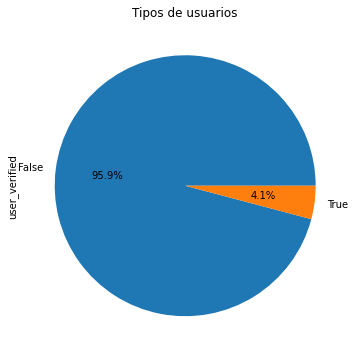

In [12]:

tweets_with_usernames.user_verified.value_counts().plot(kind='pie', title="Tipos de usuarios", autopct='%1.1f%%', figsize=(6,6))


### Podemos considerar útil conocer los dispositivos de origen de los tweets, así como la ubicación de las personas que tweetean, dividido en los segmentos que ya hemos preparado

Text(0.5, 1.0, 'Ubicación')

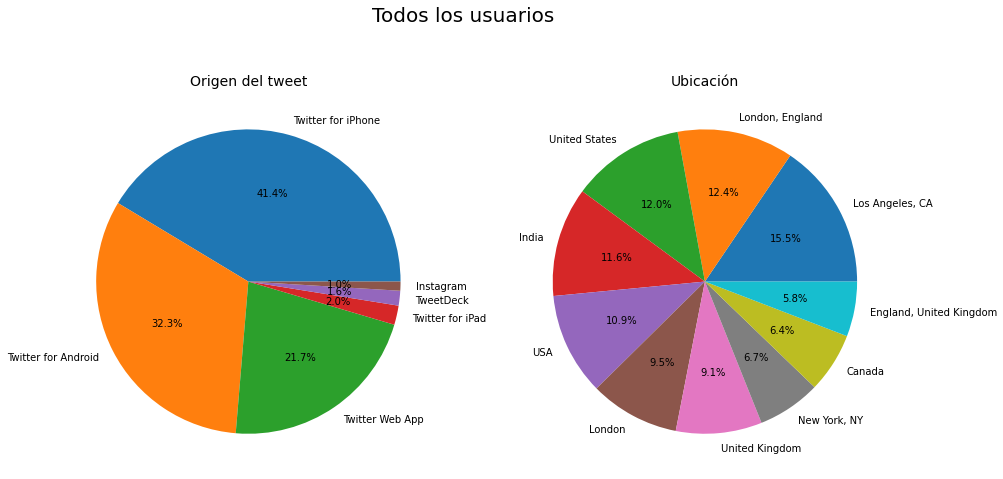

In [13]:
figura, axis = plt.subplots(nrows=1, ncols=2, figsize=[15, 8])
figura.suptitle('Todos los usuarios', fontsize=20)
axis[0].pie(tweets_with_usernames.source.value_counts().iloc[:6], labels= tweets_with_usernames.source.value_counts().iloc[:6].index, autopct='%1.1f%%')
axis[0].set_title('Origen del tweet', fontsize=14)
axis[1].pie(tweets_with_usernames.user_location.value_counts().dropna().iloc[:10], labels=tweets_with_usernames.user_location.value_counts().dropna().iloc[:10].index, autopct='%1.1f%%')
axis[1].set_title('Ubicación', fontsize=14)

Text(0.5, 1.0, 'Ubicación')

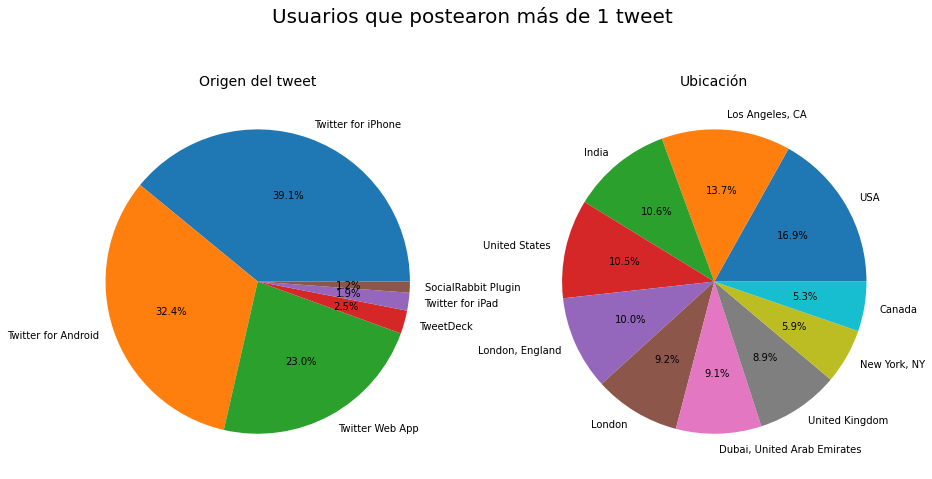

In [14]:


figura, axis = plt.subplots(nrows=1, ncols=2, figsize=[15, 8])
figura.suptitle('Usuarios que postearon más de 1 tweet', fontsize=20)
axis[0].pie(tweets_of_multiple_posting_users.source.value_counts().iloc[:6], labels= tweets_of_multiple_posting_users.source.value_counts().iloc[:6].index, autopct='%1.1f%%')
axis[0].set_title('Origen del tweet', fontsize=14)
axis[1].pie(tweets_of_multiple_posting_users.user_location.value_counts().dropna().iloc[:10], labels=tweets_of_multiple_posting_users.user_location.value_counts().dropna().iloc[:10].index, autopct='%1.1f%%')
axis[1].set_title('Ubicación', fontsize=14)

Text(0.5, 1.0, 'Ubicación')

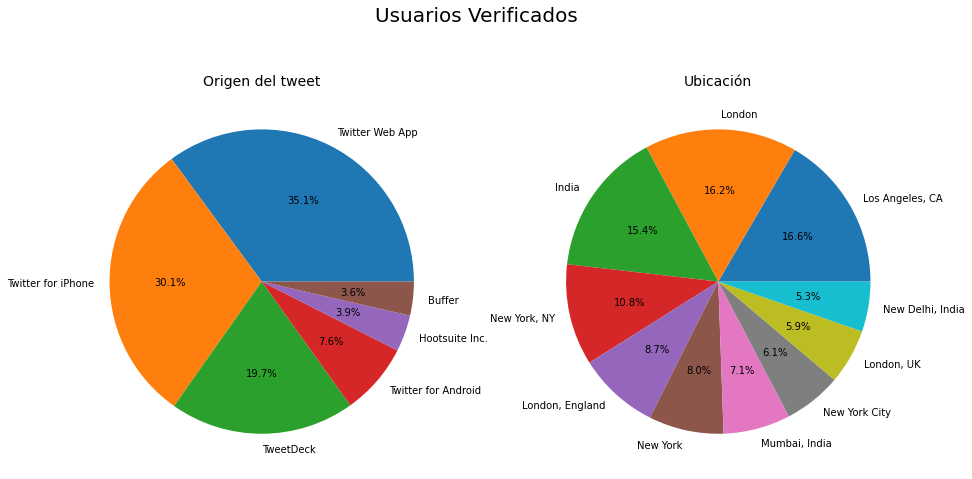

In [15]:
figura, axis = plt.subplots(nrows=1, ncols=2, figsize=[15, 8])
figura.suptitle('Usuarios Verificados', fontsize=20)
axis[0].pie(tweets_verificados.source.value_counts().iloc[:6], labels= tweets_verificados.source.value_counts().iloc[:6].index, autopct='%1.1f%%')
axis[0].set_title('Origen del tweet', fontsize=14)
axis[1].pie(tweets_verificados.user_location.value_counts().dropna().iloc[:10], labels=tweets_verificados.user_location.value_counts().dropna().iloc[:10].index, autopct='%1.1f%%')
axis[1].set_title('Ubicación', fontsize=14)

###Ahora vamos a crear una nube de palabras para poder analizar rápidamente los términos más comunes entre todos los tweets

In [16]:
texto_tweets_with_usernames = " ".join(text for text in tweets_with_usernames.text) #juntamos todo el texto en una sola variable

In [17]:


#Creamos una lista con stopwords que vamos a elminar ("STOPWORDS" de la bilbioteca wordcloud ya tiene una lista extensa, solo agregaremos algunas especificas de nuestro problema)
stopwords = set(STOPWORDS)
my_stopwords = ['#SquidGame', '#Netflix', 'https', 'co', 'Squidgame', 'squidgame', 'squidnetflix', 'got', 'really', 'see', 'project', 'will', #tal vez "will" podría quedarse si se refiere a "voluntad"...
                'squidgamenetflix', 'Netflix', 'one', 'now', 'guy', 'day', 'episode', 'make', 'watching', 'watch', 'today', 'going', 'gonna'
                'character', 'go', 'watched', 'Squid', 'Game', 'squid', 'amp', 'thing', 'show', ' Squidgame', 'us', 'play', 'player', 'man', 'serie', 'series', 'new']
stopwords.update(my_stopwords)

#no estoy seguro porque algunas de las stopwrods se alcanzan a colar, por lo que las removeré manualmente:
texto_tweets_with_usernames = texto_tweets_with_usernames.replace("SquidGame", "")
texto_tweets_with_usernames = texto_tweets_with_usernames.replace("know", "")
texto_tweets_with_usernames = texto_tweets_with_usernames.replace("game", "")



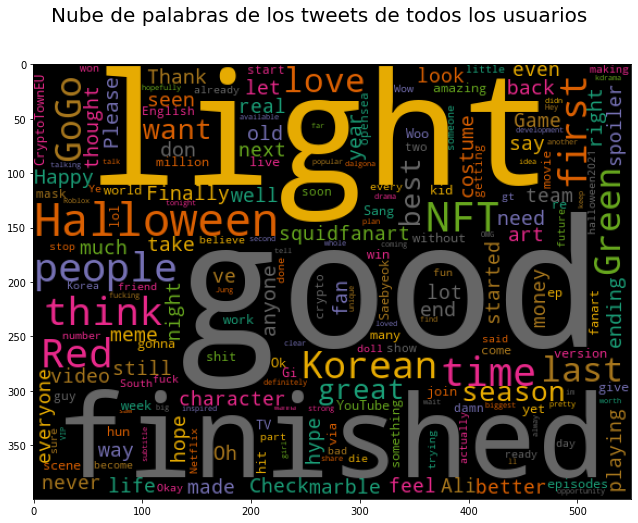

In [18]:
nubePalabras_tweets_with_usernames = WordCloud(stopwords=stopwords, width=550, height=400, max_words=200,colormap="Dark2", collocations=False).generate(texto_tweets_with_usernames)
plt.figure(figsize=(15,8))
plt.suptitle("Nube de palabras de los tweets de todos los usuarios", fontsize=20)
plt.imshow(nubePalabras_tweets_with_usernames)

##Podemos ver que la palabra "good" es de las más utilizadas, esto nos da la idea de que el sentimiento es mayoritariamente positivo. 
####comprobaremos si esta intuición es correcta, pero antes crearemos la nube de palabras de los otros segmentos de nuestra población

In [19]:
texto_tweets_multiple_posting_users = " ".join(text for text in tweets_of_multiple_posting_users.text) 

In [20]:
texto_tweets_multiple_posting_users = texto_tweets_multiple_posting_users.replace("SquidGame", "")
texto_tweets_multiple_posting_users = texto_tweets_multiple_posting_users.replace("know", "")
texto_tweets_multiple_posting_users = texto_tweets_multiple_posting_users.replace("game", "")

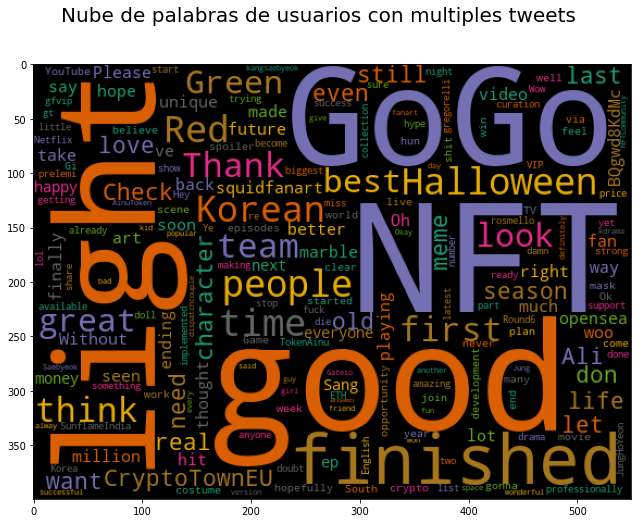

In [21]:
nubePalabras_tweets_multiple_posting_users = WordCloud(stopwords=stopwords, width=550, height=400, max_words=200,colormap="Dark2", collocations=False).generate(texto_tweets_multiple_posting_users)
plt.figure(figsize=(15,8))
plt.suptitle("Nube de palabras de usuarios con multiples tweets", fontsize=20)
plt.imshow(nubePalabras_tweets_multiple_posting_users)

####Otro insight interesante que podemos captar con la nube de palabras es que los usuarios que realizaron más de 1 tweet usaron en mayor proporción la palabra NFT, podemos imaginar que tal vez se deba a que hay bots (que publican multiples veces) intentando vender un NFT de squidgame? habría que analizar las instancias individuales que publicaron sobre NFTs para estar seguros de la razón detrás de esta tendencia... sería útil también separar a los usuarios con multiples tweets y no contarlos dentro del resto de la población porque, sospecho que NFT y crypto aparecen casi unicamente en estos usuarios. 

In [22]:
texto_tweets_verified_users = " ".join(text for text in tweets_verificados.text) 

In [23]:
texto_tweets_verified_users = texto_tweets_verified_users.replace("SquidGame", "")
texto_tweets_verified_users = texto_tweets_verified_users.replace("game", "")
texto_tweets_verified_users = texto_tweets_verified_users.replace("know", "")
texto_tweets_verified_users = texto_tweets_verified_users.replace("Netflix", "")

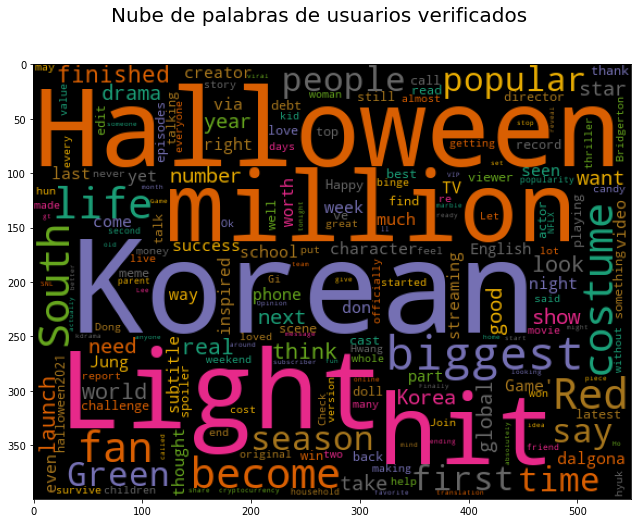

In [24]:
nubePalabras_tweets_verificado = WordCloud(stopwords=stopwords, width=550, height=400, max_words=200,colormap="Dark2", collocations=False).generate(texto_tweets_verified_users)
plt.figure(figsize=(15,8))
plt.suptitle("Nube de palabras de usuarios verificados", fontsize=20)
plt.imshow(nubePalabras_tweets_verificado)

####De nuevo podemos ver una diferencia con las palabras más utilizadas por los usuarios verificados, podemos observar que las palabras "NFT" y "crypto" ya no aparecen. veamos que pasa si eliminamos a los usuarios con tweets multiples de la población completa y volvemos a plotear la nube de datos: 

In [25]:
tweets_count_un_tweet = tweets_with_usernames.groupby('user_name').count().loc[tweets_with_usernames.groupby('user_name').count().text == 1] 
usernames_un_tweet = tweets_count_un_tweet.index
tweets_un_tweet = tweets_with_usernames.loc[tweets_with_usernames.user_name.isin(usernames_un_tweet)] 

In [26]:
texto_tweets_un_tweet = " ".join(text for text in tweets_un_tweet.text) 

In [27]:
texto_tweets_un_tweet = texto_tweets_un_tweet.replace("SquidGame", "")
texto_tweets_un_tweet = texto_tweets_un_tweet.replace("game", "")
texto_tweets_un_tweet = texto_tweets_un_tweet.replace("know", "")
texto_tweets_un_tweet = texto_tweets_un_tweet.replace("Netflix", "")

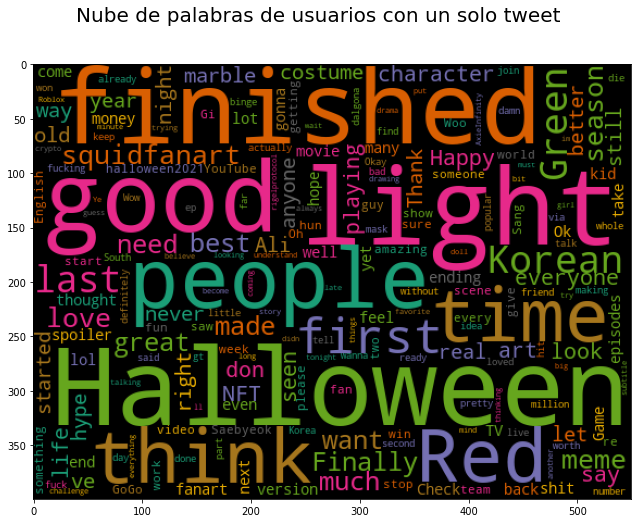

In [28]:
nubePalabras_un_tweet = WordCloud(stopwords=stopwords, width=550, height=400, max_words=200,colormap="Dark2", collocations=False).generate(texto_tweets_un_tweet)
plt.figure(figsize=(15,8))
plt.suptitle("Nube de palabras de usuarios con un solo tweet", fontsize=20)
plt.imshow(nubePalabras_un_tweet)

###Parece que nuestra intuición es correcta, las palabras "NTF" y "Crypto" aparecen mucho únicamente en los tweets de usuarios que publicaron más de 1. habría que hacer aún más análisis para determinar si es porque son bots tratando de vender NFT/Cryptomonedas pero creo que es muy posible, en especial con las noticias de esta semana sobre la estafa con la criptomoneda de Squidgame (SQUID) 
#####[Más info sobre la estafa](https://www.wired.com/story/squid-game-coin-crypto-scam/)

---

#Sentiment Analysis

####Crear funciones para obtener la polaridad del sentimiento y la subjetividad, podemos utilizar la subjetividad para quedarnos solamente con las instancias donde la clasificación es más certera (objetiva)
#####Polaridad cerca de -1 es un sentimiento negativo y cerca de +1 es positivo
#####Subjetividad cerca de 0 es objetiva y cerca de 1 es subjetiva

In [29]:
def getPolarity(row):
  sentiment = TextBlob(row.text).sentiment
  return sentiment.polarity

def getSubjectivity(row):
  sentiment = TextBlob(row.text).sentiment
  return sentiment.subjectivity


##Todos los usuarios

In [30]:
tweets_with_sentiment = tweets_with_usernames
tweets_with_sentiment['sentiment_polarity'] = tweets_with_sentiment.apply(getPolarity, axis = 'columns') #apply es mucho más rápido que usar iterrows o itertuples o algo asi en un DF
tweets_with_sentiment['sentiment_Subjectivity'] = tweets_with_sentiment.apply(getSubjectivity, axis = 'columns') 
#tweets_with_sentiment.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###Promedio del sentimiento de los tweets: 

In [31]:
tweets_with_sentiment.sentiment_polarity.mean()

0.06112149014127421

In [32]:
tweets_with_sentiment.sentiment_Subjectivity.mean()

0.37116637013750664

####Cantidad de tweets positivos:

In [33]:
all_pos_tweets = tweets_with_sentiment.loc[tweets_with_sentiment.sentiment_polarity > 0].text.count() 
all_pos_tweets

31058

####Cantidad de tweets neutrales:

In [34]:
all_neutral_tweets = tweets_with_sentiment.loc[tweets_with_sentiment.sentiment_polarity == 0].text.count() 
all_neutral_tweets

29061

####Cantidad de tweets negativos:

In [35]:
all_negative_tweets = tweets_with_sentiment.loc[tweets_with_sentiment.sentiment_polarity < 0].text.count()
all_negative_tweets

19896

Text(0.5, 1.0, 'Sentimiento en todos los tweets')

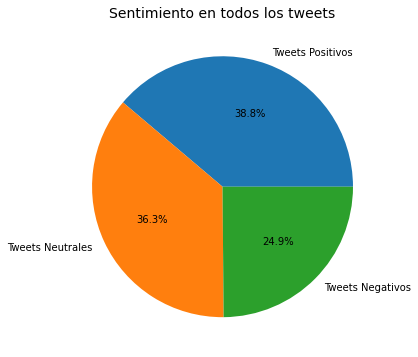

In [36]:
plt.figure(figsize=(8,6))
axs = plt.axes()
axs.pie([all_pos_tweets, all_neutral_tweets, all_negative_tweets], labels= ["Tweets Positivos", "Tweets Neutrales", "Tweets Negativos"], autopct='%1.1f%%')
axs.set_title('Sentimiento en todos los tweets', fontsize=14)

###Podemos ver que se cumple lo que pensabamos al ver las nubes de palabras, la mayoría de los tweets tienen un sentimiento positivo, ahora analicemos solamente los tweets de usuarios verificados:

##Usuarios verificados

In [37]:
verified_tweets_with_sentiment = tweets_verificados
verified_tweets_with_sentiment['sentiment_polarity'] = verified_tweets_with_sentiment.apply(getPolarity, axis = 'columns') #apply es mucho más rápido que usar iterrows o itertuples o algo asi en un DF
verified_tweets_with_sentiment['sentiment_Subjectivity'] = verified_tweets_with_sentiment.apply(getSubjectivity, axis = 'columns') 
#verified_tweets_with_sentiment.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###Promedio del sentimiento de los tweets: 

In [38]:
verified_tweets_with_sentiment.sentiment_polarity.mean()

0.07980952030539268

In [39]:
verified_tweets_with_sentiment.sentiment_Subjectivity.mean()

0.33610339096119973

####Cantidad de tweets positivos:

In [40]:
ver_pos_tweets = verified_tweets_with_sentiment.loc[verified_tweets_with_sentiment.sentiment_polarity > 0].text.count() 
ver_pos_tweets

1326

####Cantidad de tweets neutrales:

In [41]:
ver_neutral_tweets = verified_tweets_with_sentiment.loc[verified_tweets_with_sentiment.sentiment_polarity == 0].text.count() 
ver_neutral_tweets

1313

####Cantidad de tweets negativos:

In [42]:
ver_neg_tweets = verified_tweets_with_sentiment.loc[verified_tweets_with_sentiment.sentiment_polarity < 0].text.count() 
ver_neg_tweets

662

Text(0.5, 1.0, 'Sentimiento en tweets verificados')

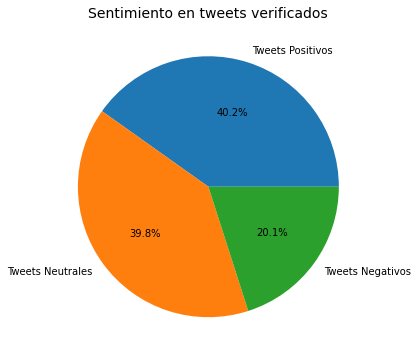

In [43]:
plt.figure(figsize=(8,6))
axs = plt.axes()
axs.pie([ver_pos_tweets, ver_neutral_tweets, ver_neg_tweets], labels= ["Tweets Positivos", "Tweets Neutrales", "Tweets Negativos"], autopct='%1.1f%%')
axs.set_title('Sentimiento en tweets verificados', fontsize=14)

###Podemos observar que la tendencia se mantiene e incluso es más fuerte en los tweets de usuarios verificados

####Ahora analicemos los twets de las personas que solo tweetearon 1 vez y de quien tweeteo más de 1 vez (que sospechamos contienen muchos bots)

##Usuarios de 1 solo tweet

In [44]:
tweets_un_tweet_with_sentiment = tweets_un_tweet
tweets_un_tweet_with_sentiment['sentiment_polarity'] = tweets_un_tweet_with_sentiment.apply(getPolarity, axis = 'columns') #apply es mucho más rápido que usar iterrows o itertuples o algo asi en un DF
tweets_un_tweet_with_sentiment['sentiment_Subjectivity'] = tweets_un_tweet_with_sentiment.apply(getSubjectivity, axis = 'columns') 
#tweets_un_tweet_with_sentiment.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###Promedio del sentimiento de los tweets: 

In [45]:
tweets_un_tweet_with_sentiment.sentiment_polarity.mean()

0.052496387328138355

In [46]:
tweets_un_tweet_with_sentiment.sentiment_Subjectivity.mean()

0.36744873442083237

####Cantidad de tweets positivos:

In [47]:
un_tweet_pos = tweets_un_tweet_with_sentiment.loc[tweets_un_tweet_with_sentiment.sentiment_polarity > 0].text.count() 
un_tweet_pos

16157

####Cantidad de tweets neutrales:

In [48]:
un_tweet_neutral = tweets_un_tweet_with_sentiment.loc[tweets_un_tweet_with_sentiment.sentiment_polarity == 0].text.count() 
un_tweet_neutral

16069

####Cantidad de tweets negativos:

In [49]:
un_tweet_neg = tweets_un_tweet_with_sentiment.loc[tweets_un_tweet_with_sentiment.sentiment_polarity < 0].text.count() 
un_tweet_neg

11206

Text(0.5, 1.0, 'Sentimiento en tweets de usuarios que solo hicieron 1 tweet')

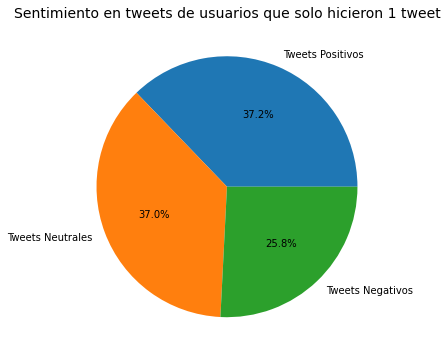

In [50]:
plt.figure(figsize=(8,6))
axs = plt.axes()
axs.pie([un_tweet_pos, un_tweet_neutral, un_tweet_neg], labels= ["Tweets Positivos", "Tweets Neutrales", "Tweets Negativos"], autopct='%1.1f%%')
axs.set_title('Sentimiento en tweets de usuarios que solo hicieron 1 tweet', fontsize=14)

##Usuarios con multiples tweets

In [51]:
tweets_multiple_posts_with_sentiment = tweets_of_multiple_posting_users
tweets_multiple_posts_with_sentiment['sentiment_polarity'] = tweets_multiple_posts_with_sentiment.apply(getPolarity, axis = 'columns') #apply es mucho más rápido que usar iterrows o itertuples o algo asi en un DF
tweets_multiple_posts_with_sentiment['sentiment_Subjectivity'] = tweets_multiple_posts_with_sentiment.apply(getSubjectivity, axis = 'columns') 
#tweets_multiple_posts_with_sentiment.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


###Promedio del sentimiento de los tweets: 

In [52]:
tweets_multiple_posts_with_sentiment.sentiment_polarity.mean()

0.07136136837378437

In [53]:
tweets_multiple_posts_with_sentiment.sentiment_Subjectivity.mean()

0.3755800145746482

####Cantidad de tweets positivos:

In [54]:
multiple_tweets_pos = tweets_multiple_posts_with_sentiment.loc[tweets_multiple_posts_with_sentiment.sentiment_polarity > 0].text.count() 
multiple_tweets_pos

14901

####Cantidad de tweets neutrales:

In [55]:
multiple_tweets_neutral = tweets_multiple_posts_with_sentiment.loc[tweets_multiple_posts_with_sentiment.sentiment_polarity == 0].text.count() 
multiple_tweets_neutral

12992

####Cantidad de tweets negativos:

In [56]:
multiple_tweets_neg = tweets_multiple_posts_with_sentiment.loc[tweets_multiple_posts_with_sentiment.sentiment_polarity < 0].text.count() 
multiple_tweets_neg

8690

Text(0.5, 1.0, 'Sentimiento en tweets de usuarios con >1 tweet')

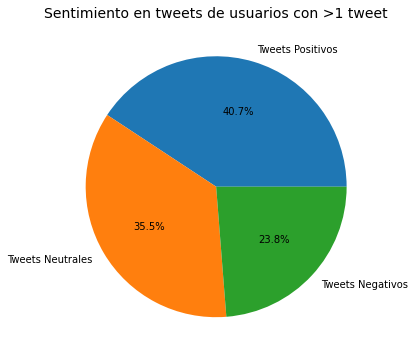

In [57]:
plt.figure(figsize=(8,6))
axs = plt.axes()
axs.pie([multiple_tweets_pos, multiple_tweets_neutral, multiple_tweets_neg], labels= ["Tweets Positivos", "Tweets Neutrales", "Tweets Negativos"], autopct='%1.1f%%')
axs.set_title('Sentimiento en tweets de usuarios con >1 tweet', fontsize=14)

#Conclusiones

##Dos terceras partes de Los usuarios en esta base de datos prefieren utilizar sus teléfonos para hacer tweets y de ellos la mayoría utiliza un iphone, después del celular el sitio web de twitter es la forma más utilizada y solo menos del 5% de los usuarios realizan tweets por un medio diferente. El lugar de origen de los tweets es mayoritariamente Estados Unidos y Reino Unido, que ocupan el 82% del total, seguidos por la India y Canadá, lo cual es interesante porque la India tiene muchos más hablantes nativos de Inglés que el Reino Unido y aún así solo tiene el 11.6% de los usuarios en este set de datos. Si nos enfocamos únicamente en usuarios verificados la historia es diferente, estos usuarios tienen una proporción menor de uso de celular, sobre todo de Android y casi el 20% utiliza tweetdeck para realizar sus tweets, lo cual tiene mucho sentido ya que para un usuario normal tal vez no vale la pena utilizar tweetdeck. Entre los usuarios verificados podemos observar que India retoma terreno teniendo casi la misma proporción de usuarios que el Reino Unido (27.8% y 30.8% respectivamente) mientras que Estados Unidos se mantiene a la cabeza con 41.5%.

##Analizando el contenido de los tweets podemos observar algunas tendencias, la más clara es que la palabra "good" aparece mucho lo que nos indica que el sentimiento probablemente es en su mayoría positivo, lo que pudimos comprobar al hacer análisis de sentimiento, donde encontramos que los tweets con sentimientos negativos son solamente al rededor de una cuarta parte del total. Otra tendencia que me parece interesante es que en los tweets de personas que postearon múltiples tweets aparecen mucho palabras relacionadas con criptomonedas y NTFs, esta semana salió una noticia de una estafa con una criptomoneda inspirada en SquidGame por lo que no me parece que sea coincidencia el alto número de menciones de estas palabras, hace falta analizar mejor estos tweets específicos para descubrir si su aparición se debe a la popularidad de la noticia o a bots o personas intentando atraer a usuarios de twiter a que compraran esta criptomoneda para después estafarlos, teniendo más tiempo me interesaría seguir explorando esta línea. 
